# Piano to Sheet

Converting .wav piano pieces into music sheets.

I

## Pipeline break down ( beta)

1. Loading in the wave file,
2. 



## Audio Processing  Libraries

In [ ]:
pip install tqdm

For the processing libraries, we will be using pretty_midi to extract out label information from the given midi files.  
And for processing our wav audio files. We will be using librosa.

## Machine Learning Lib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import librosa 
import json

import csv
import pandas as pd
import pretty_midi as pm
import mido
import IPython.display as ipd
import torch
from scipy.signal import resample
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import math
import time
import pickle

# Model Saving funtion and Model loading function

Having a model saving function and a modle loading function in which we can train the model in small epoch progress.

# Preprocessing the data

In [2]:

labels_file_path = "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/maestro-v3.0.0.json"
with open(labels_file_path, 'r') as file:
    data = json.load(file)

all_sets = {}
all_sets['train'] = []
all_sets['validation'] = []
all_sets['test'] = []

def sortingsets (data, allsets):
    for key in data:
       
        if data[key] == 'train':
            all_sets['train'].append(key)
        elif data[key] == 'validation':
            all_sets['validation'].append(key)
        else:
            all_sets['test'].append(key)

def save_index_to_csv(all_sets):
    for key in all_sets:
        path = f"traindata/maestro-v3.0.0-midi/maestro-v3.0.0/{key}_indicies.csv"
        df = pd.DataFrame({'Index': all_sets[key]})
        df.to_csv(path, index=False)

def load_index_from_csv(path):
    indices = []
    with open(path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            indices.append(int(row[0]))
    return indices

def save_progress_index_to_csv(indices, epoch, id):
    path = f"models/training_index{epoch}_for_{id}.csv"
    df = pd.DataFrame({'Index': indices})
    df.to_csv(path, index=False)

def load_progress_index_from_csv(epoch, id):
    path = f"models/training_index{epoch}_for_{id}.csv"
    indices = []
    with open(path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            indices.append(int(row[0]))
    return indices

sortingsets(data['split'], all_sets)
save_index_to_csv(all_sets)




traindata/maestro-v3.0.0-midi/maestro-v3.0.0/train_indicies.csv  
traindata/maestro-v3.0.0-midi/maestro-v3.0.0/test_indicies.csv   
traindata/maestro-v3.0.0-midi/maestro-v3.0.0/validation_indicies.csv

### Data Preprocessing
implenting utility functions such as the randomizing the data set for training.

In [3]:
### making the random seed 
np.random.seed(40)

In [4]:
## Randomizing the data set index for training purposes
def randomizeing(data_set):
    ds = np.array(data_set)
    np.random.shuffle(ds)
    return ds

## Select n indices from the givien data set
def select_N_randomized_from_set(n, data_set):
    nparry = randomizeing(data_set)
    return nparry[:n]


## ----- ----- ---------- loading function ------------------------------ ##

## function loading in the wav function
def load_wav_from_index(index):
    labels_file_path = "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/maestro-v3.0.0.json"
    with open(labels_file_path, 'r') as file:
        data = json.load(file)
    wav_path = "traindata/maestro-v3.0.0/maestro-v3.0.0/" + data['audio_filename'][str(index)]
    
    return librosa.load(wav_path, sr=None)

## function loading in the midi function
def load_midi_from_index(index):
    labels_file_path = "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/maestro-v3.0.0.json"
    with open(labels_file_path, 'r') as file:
        data = json.load(file)
    midi_path = "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/" + data['midi_filename'][str(index)]
    return pm.PrettyMIDI(midi_path)

## ----- ----- -------- Path showing function-------------------------------- ##
    
## showing the file path audio of the wave
def show_wav_path(index):
    labels_file_path = "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/maestro-v3.0.0.json"
    with open(labels_file_path, 'r') as file:
        data = json.load(file)
    wav_path = "traindata/maestro-v3.0.0/maestro-v3.0.0/" + data['audio_filename'][str(index)]
    return wav_path

## Showing the file path of the midi file of data[index]
def show_midi_path(index):
    labels_file_path = "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/maestro-v3.0.0.json"
    with open(labels_file_path, 'r') as file:
        data = json.load(file)
    midi_path = "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/" + data['midi_filename'][str(index)]
    return midi_path

## loading in the wav and midi pair
def load_wav_midi_pair(index): ## (wav, midi)
    return load_wav_from_index(index), load_midi_from_index(index)

In [ ]:
train_data = load_index_from_csv("traindata/maestro-v3.0.0-midi/maestro-v3.0.0/train_indicies.csv")
print(len(train_data))
subset_train_data = select_N_randomized_from_set(50, train_data)

print(len(subset_train_data))

# AUDIO EXPERIMENTATION

In [5]:
(wav, sr), midi = load_wav_midi_pair(1025)
# midi = load_midi_from_index(1025)


In [9]:
ballade1, sr = load_wav_from_index(505)

noised_ballade1 = add_gaussian_noise(ballade1, noise_level=0.01)

NameError: name 'add_gaussian_noise' is not defined

In [ ]:
print(len(ballade1))

In [ ]:
print(len(noised_ballade1))

In [ ]:
wav, sr = load_wav_from_index(216)


ipd.Audio(data= wav, rate= sr)


### Audio Preprocessing functions

#### Pretty_midi note
The MIDI object is used from the python package pretty_midi.  
Using pretty_midi range from 0 to 127. we can later tranform this into the range of 0 to 87 to match a piano

In [10]:



""" This function extracts all played notes in the midi Object, which it will be futher trained with the aligne ed wave object
    input: pm object
    It is good for debugging and seeing the midi object
"""
def extract_midi_notes(midi, format = "piano_roll", fs=1000):
    if (format == "piano_roll"):
        return extract_midi_notes_piano_roll(midi, fs)
    else:
        return extract_midi_notes_raw(midi)



def extract_midi_notes_raw(midi):
    """This function extract from the raw midi instrument for the midi information"""
    notes = []
    for instrument in midi.instruments:
        for note in instrument.notes:
            notes.append({
                'pitch': note.pitch,
                'start': note.start,
                'end': note.start + note.get_duration(),
                'velocity': note.velocity
            })
    #preprocessing the sort
    notes.sort(key=(lambda x: x['start']))
    return notes


def extract_midi_notes_piano_roll(midi, fs):
    """This function extract from the piano row of the instruments for the midi information"""
    notes = []
    piano_roll = midi.get_piano_roll(fs=fs)
    time_step = 1 / fs  # Duration of each time frame in seconds

    # Iterate over each pitch (row in the piano roll)
    for pitch, row in enumerate(piano_roll):
        active = False
        note_start = None
        velocity = 0

        for t, value in enumerate(row):
            if value > 0 and not active:  # Note starts
                active = True
                note_start = t * time_step
                velocity = value
            elif value == 0 and active:  # Note ends
                active = False
                note_end = t * time_step
                notes.append({
                    'pitch': pitch,
                    'start': note_start,
                    'end': note_end,
                    'velocity': velocity
                })

        # If a note is still active at the end of the piano roll
        if active:
            note_end = len(row) * time_step
            notes.append({
                'pitch': pitch,
                'start': note_start,
                'end': note_end,
                'velocity': velocity
            })

    # Sort the notes by start time
    notes.sort(key=lambda x: x['start'])
    return notes




""" Wrting a peekable Generator for midi object"""
class PeekableGenerator:
    def __init__(self, generator):
        self._generator = generator
        self._next_item = None
        self._has_next = False
        self._advance()

    def _advance(self):
        try:
            self._next_item = self._generator.__next__()
            self._has_next = True
        except StopIteration:
            self._next_item = None
            self._has_next = False

    def peek(self):
        if not self._has_next:
            raise StopIteration("No more elements to peek at.")
        return self._next_item

    def __next__(self):
        if not self._has_next:
            raise StopIteration("No more elements.")
        current = self._next_item
        self._advance()
        return current

    def has_next(self):
        return self._has_next

    def __iter__(self):
        yield self._next_item
        self._advance()

    

"""Generator to yield midi note object at the frame during the classification
    input: pm object
"""
def midi_yielding(midi):
    all_midi_obj :list = extract_midi_notes(midi)
    ##Processing
    for note in all_midi_obj:
        yield note


""" Yielding a list of midi notes information where it fits the time frame automatically.
    Implemented using overlapping frame structure for the training.
    Begin at 0, the frame jumping at the speed of jump_len, the size of the frame is frame_len
    This function will yield the frame at the given parameter.
"""
def frame_aligning_midi(t: int, jump_len:int, frame_len: int, sr:int, midi):
    midi_generator = PeekableGenerator(midi_yielding(midi))
    midi_labels = []

    jump_time_fraction: float = jump_len * (1/sr)
    frame_time_fraction: float = frame_len * (1/sr)
    framing = [t*jump_time_fraction, t*jump_time_fraction + frame_time_fraction]
    
    last_note = 0
    while midi_generator.has_next() or last_note > framing[0]:
        
        while midi_generator.has_next() and midi_generator.peek()['start'] >= framing[0] and midi_generator.peek()['start'] < framing[1]:
            try:
                midi_labels.append(midi_generator.__next__())
            except StopIteration:
                print("Generator exhausted, no Midi Objectis being added to the label")
                break
        
        ## Yielding the list of midi notes that are fitted in side the frame
        yield midi_labels

        midi_labels.sort(key=(lambda x: x['end']))
        ##calculating the next frame time step and removing the items from the previous frame
        framing [0] += jump_time_fraction
        framing [1] += jump_time_fraction
        while len(midi_labels) > 0 and midi_labels[0]['end'] < framing[0]:
            midi_labels.pop(0)
        
        if len(midi_labels) > 0 and midi_labels[0]['end'] > framing[0]:
            last_note = midi_labels[0]['end']

    
        
  



    
""" This function returns the aligned frame at the wav data,"""
def frame_aligning_wav(t: int, jump_len: int, frame_len: int, wav):
    begin = t * jump_len
    return wav[begin: begin + frame_len]


""" This function returns the amount seconds of audio data from the wav, began on t, while using  """

def audio_segment_of(t: int, wav, seconds: float, sr: int, jump_len: int = 512, frame_len: int = 2048, ):
    size = int(seconds*sr)
    begin = t*jump_len
    
    return wav[begin: begin + size]

def audio_segment_between(begin, end, wav, sr):
    return wav[int(begin*sr): int(end*sr)]

    


(128, 54507)

### Constructing Different Spectrogram From wav frames

In [11]:
def extract_mel_spectrogram(audio, sr, n_mels=88, hop_length=512, n_fft=4096): ##_fft is the frame length 
    """
    Extract a mel-spectrogram from raw audio.
    """
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft
    )
    # Convert to log scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def extract_cqt_spectrogram(audio, sr, n_bins=88, bins_per_octave=12, hop_length=512):
    """ 
    Extract a CQT_spectrogram from raw audio
    """
    cqt = librosa.cqt(
        y=audio, sr=sr, n_bins=n_bins, bins_per_octave=bins_per_octave, hop_length=hop_length
    )
    cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)
    return cqt_db

def extract_hcqt_spectrogram(audio, sr, n_bins=88, bins_per_octave=12, hop_length=512, harmonics=[1, 2, 3]):
    """
    Extract a Harmonic Constant-Q Transform (HCQT) spectrogram.
    """
    hcqt = []
    max_bins = n_bins
    max_frame = 0
    for h in harmonics:
        cqt = librosa.cqt(audio, sr=sr, hop_length=hop_length, n_bins=n_bins, bins_per_octave=bins_per_octave, fmin=librosa.note_to_hz('C1') * h)
        hcqt.append(cqt)
        max_frame = max(max_frame, cqt.shape[1]) 
    
    #Stack and align all of the cqt
    aligned_hcqt = []
    for cqt in hcqt:
        # Pad frequency bins
        if cqt.shape[0] < max_bins:
            cqt = np.pad(cqt, ((0, max_bins - cqt.shape[0]), (0, 0)), mode="constant")
        # Pad temporal frames
        if cqt.shape[1] < max_frame:
            cqt = np.pad(cqt, ((0, 0), (0, max_frame - cqt.shape[1])), mode="constant")
        # Crop to align dimensions (optional, if needed)
        cqt = cqt[:max_bins, :max_frame]
        aligned_hcqt.append(cqt)
    
    aligned_hcqt = np.stack(aligned_hcqt, axis=0)
    
    # Convert to dB
    hcqt_db = librosa.amplitude_to_db(np.abs(aligned_hcqt), ref=np.max)
    return hcqt_db


def extract_chroma_gram_cqt(audio, sr, hop_length=512 ):
    chromagram = librosa.feature.chroma_cqt(audio, sr=sr, hop_length=hop_length)
    return chromagram

(88, 431)


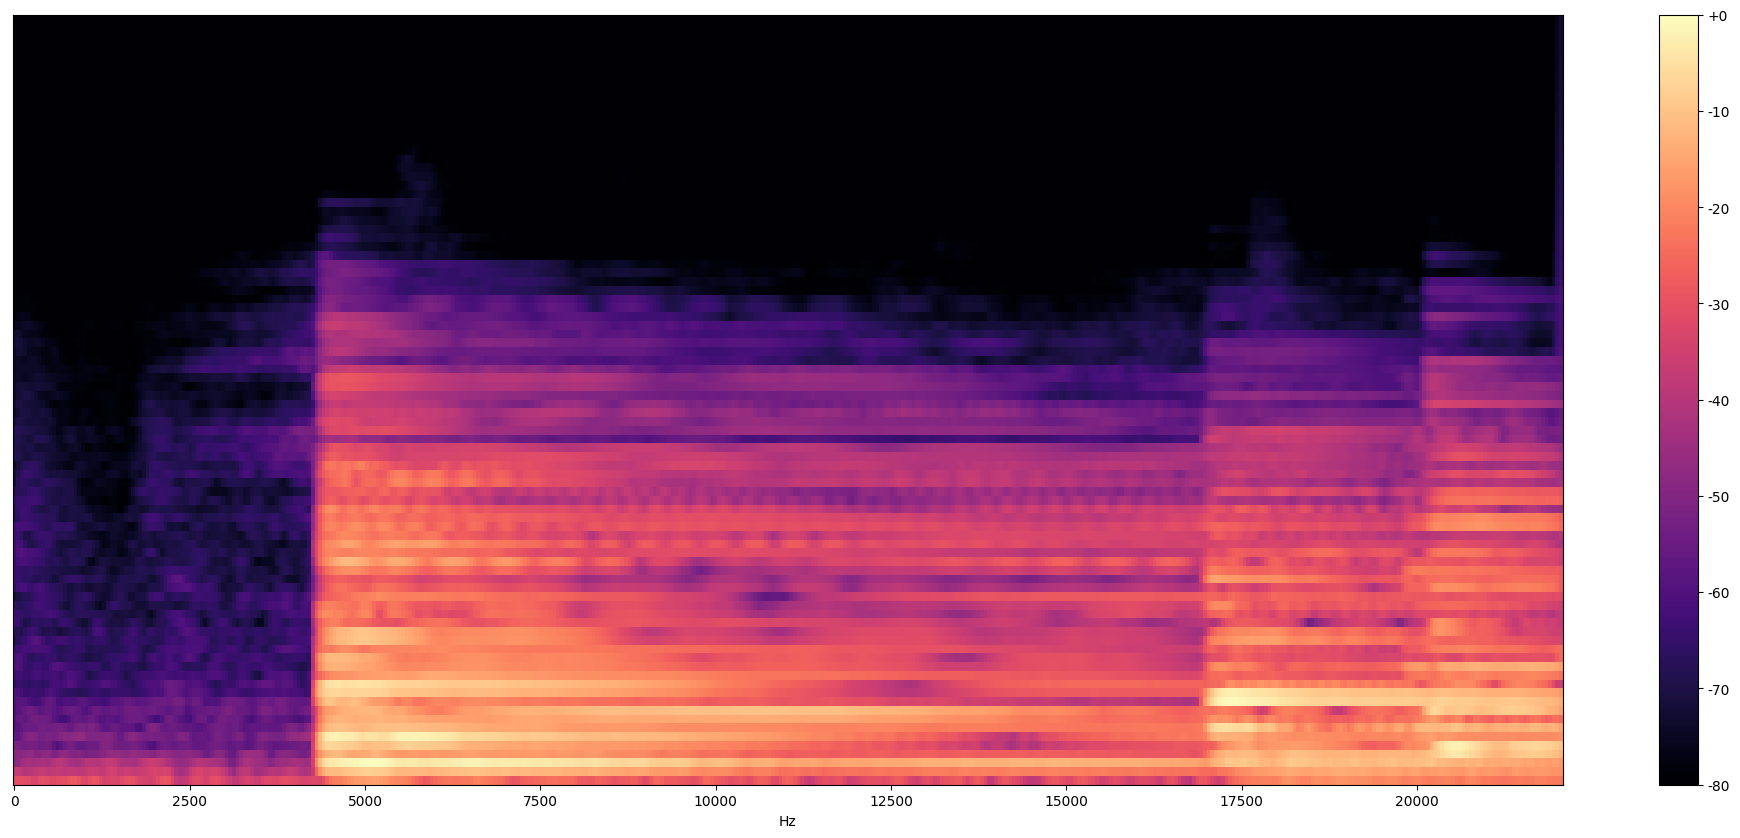

(3, 88, 431)


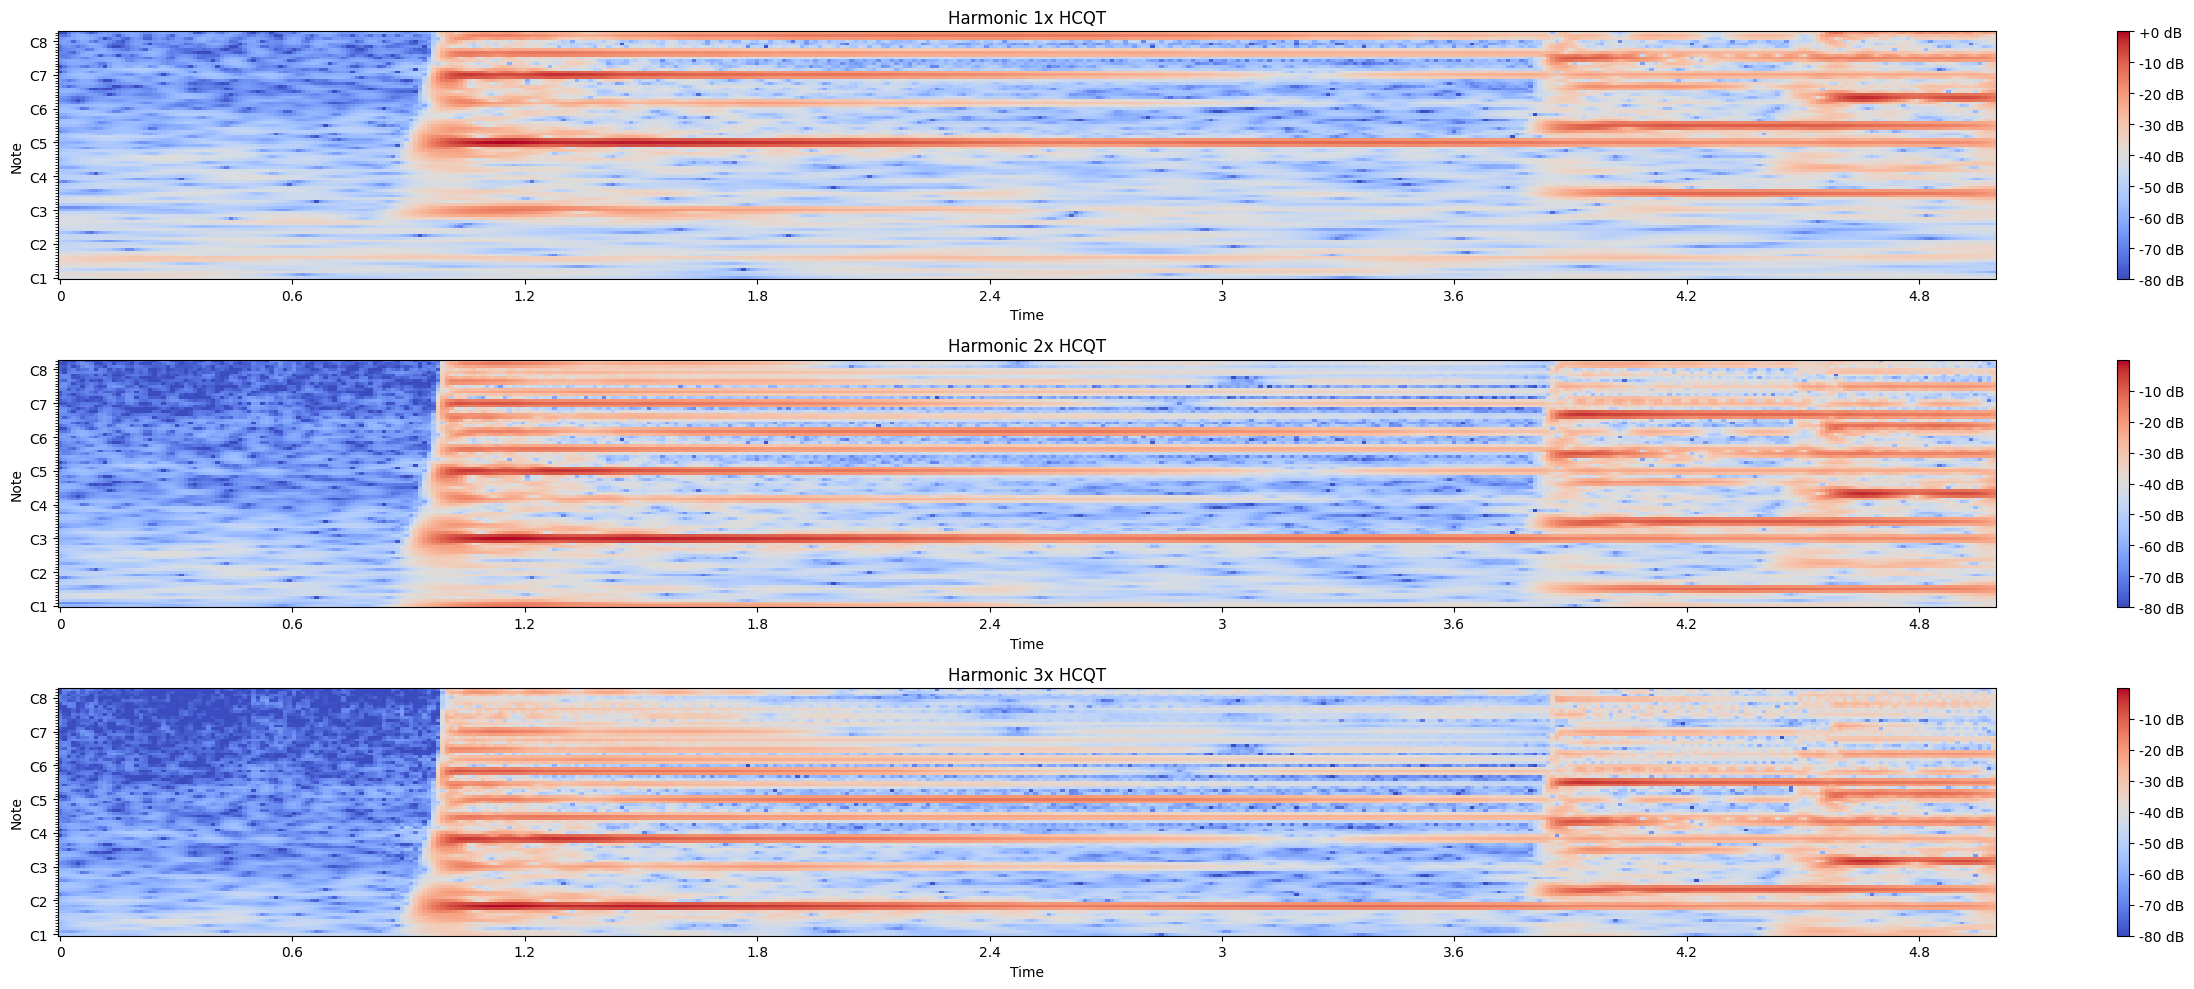

In [63]:
# Example audio input
ballade1, sr = load_wav_from_index(505)
frame_time = 2048 /sr
num_frame = 22
audio1 = audio_segment_between(0,5,ballade1, sr)
quick_sample = audio_segment_between(0, num_frame*frame_time, ballade1, sr)
mel_spectrogram = extract_mel_spectrogram(audio1, sr, n_mels =88)
print(mel_spectrogram.shape)


plt.figure(figsize=(25, 10))
librosa.display.specshow(mel_spectrogram, 
                         sr=sr, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()
ipd.Audio(data= audio1, rate= sr)


hcqt = extract_hcqt_spectrogram(audio1, sr, n_bins=88, bins_per_octave=24)  # Adjust bins_per_octave as needed
print(hcqt.shape)

# Visualization
plt.figure(figsize=(25, 10))
for i, harmonic in enumerate([1, 2, 3]):
    plt.subplot(3, 1, i + 1)
    librosa.display.specshow(hcqt[i, :, :], sr=sr, hop_length=512, x_axis="time", y_axis="cqt_note", cmap="coolwarm")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Harmonic {harmonic}x HCQT")
plt.tight_layout()
plt.show()



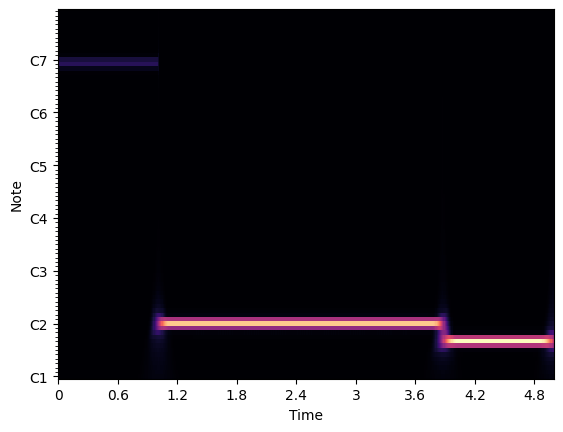

In [12]:
ballade1, sr = load_wav_from_index(505)
frame_time = 2048 /sr
num_frame = 22
audio1 = audio_segment_between(0,5,ballade1, sr)
hop_length = 512
onset_env = librosa.onset.onset_strength(y=audio1, sr=sr, hop_length=hop_length)


onset_samples = librosa.onset.onset_detect(y=audio1,
                                           sr=sr, units='samples', 
                                           hop_length=hop_length, 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

onset_boundaries = np.concatenate([[0], onset_samples, [len(audio1)]])
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

y = np.concatenate([
    estimate_pitch_and_generate_sine(audio1, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])
cqt = librosa.cqt(y, sr=sr)
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')

In [ ]:
ipd.Audio(y, rate=sr)

In [51]:
ballade1, sr = load_wav_from_index(505)
audio1 = audio_segment_between(509, 510, ballade1, sr)
(ballade1, sr), midi = load_wav_midi_pair(505)

extract_midi_notes_from_midi(midi, 100)

[{'pitch': 36, 'start': 0.98, 'end': 5.53, 'velocity': np.float64(83.0)},
 {'pitch': 48, 'start': 0.98, 'end': 6.98, 'velocity': np.float64(87.0)},
 {'pitch': 51, 'start': 3.84, 'end': 5.53, 'velocity': np.float64(72.0)},
 {'pitch': 39, 'start': 3.88, 'end': 5.53, 'velocity': np.float64(51.0)},
 {'pitch': 44, 'start': 4.48, 'end': 5.53, 'velocity': np.float64(55.0)},
 {'pitch': 56,
  'start': 4.5600000000000005,
  'end': 5.53,
  'velocity': np.float64(75.0)},
 {'pitch': 58, 'start': 5.04, 'end': 5.54, 'velocity': np.float64(80.0)},
 {'pitch': 46,
  'start': 5.1000000000000005,
  'end': 5.53,
  'velocity': np.float64(46.0)},
 {'pitch': 60, 'start': 5.45, 'end': 11.18, 'velocity': np.float64(75.0)},
 {'pitch': 56, 'start': 5.83, 'end': 6.98, 'velocity': np.float64(66.0)},
 {'pitch': 44, 'start': 5.86, 'end': 6.98, 'velocity': np.float64(47.0)},
 {'pitch': 63, 'start': 6.15, 'end': 6.98, 'velocity': np.float64(76.0)},
 {'pitch': 51, 'start': 6.17, 'end': 6.98, 'velocity': np.float64(47.0)

In [52]:
extract_midi_notes(midi)

[{'pitch': 48,
  'start': np.float64(0.9854166666666666),
  'end': np.float64(1.809375),
  'velocity': 87},
 {'pitch': 36,
  'start': np.float64(0.9874999999999999),
  'end': np.float64(1.8968749999999999),
  'velocity': 83},
 {'pitch': 51,
  'start': np.float64(3.8489583333333335),
  'end': np.float64(4.692708333333333),
  'velocity': 72},
 {'pitch': 39,
  'start': np.float64(3.8822916666666667),
  'end': np.float64(4.25625),
  'velocity': 51},
 {'pitch': 44,
  'start': np.float64(4.486458333333333),
  'end': np.float64(5.198958333333334),
  'velocity': 55},
 {'pitch': 56,
  'start': np.float64(4.561458333333333),
  'end': np.float64(5.186458333333333),
  'velocity': 75},
 {'pitch': 58,
  'start': np.float64(5.04375),
  'end': np.float64(5.541666666666667),
  'velocity': 80},
 {'pitch': 46,
  'start': np.float64(5.105208333333334),
  'end': np.float64(5.397916666666666),
  'velocity': 46},
 {'pitch': 60,
  'start': np.float64(5.457291666666666),
  'end': np.float64(5.691666666666666),

### Calculating the added noise level to the wav function.

In [14]:
def compute_noise_power(audio, snr_dB):
    """
    Compute the noise power needed for a given SNR in dB.
    :param audio: NumPy array of the audio signal.
    :param snr_dB: Desired Signal-to-Noise Ratio in dB.
    :return: Noise power.
    """
    # Calculate signal power (mean squared amplitude)
    signal_power = np.mean(audio ** 2)
    
    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_dB / 10)
    
    # Calculate noise power
    noise_power = signal_power / snr_linear
    return noise_power





In [15]:
def add_gaussian_noise(audio, noise_level=0.0006):
    
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise




### Model for musheet


In [16]:
class PianoNoteModel(nn.Module):
    def __init__(self, num_mel_bins=88, mel_temporal_length=89, num_frame_output=22, output_size=(88, 3)):
        """The default parameter is approximated for 1 seconds of audio data, regarding to the temporal_length"""
        super(PianoNoteModel, self).__init__()

        self.num_mel_bins = num_mel_bins
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
        # Compute flattened size based on input dimensions after pooling
        # Assuming input shape is (batch_size, 1, num_mel_bins, num_frames)
        pooled_mel_bins = num_mel_bins // 2  # Adjust based on pooling
        pooled_temporal_length = mel_temporal_length // 2     # Adjust based on pooling

        
        flattened_size = pooled_mel_bins * pooled_temporal_length * 64  # Based on conv2 output channels
        
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, num_frame_output * output_size[0] * output_size[1])  # Predict for each frame
        
    def forward(self, x):
        # Input shape: (batch_size, 1, num_mel_bins, num_frames)
        
        # Convolutional layers
        
        x = F.relu(self.conv1(x))

       

        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.dropout(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten except batch dimension
       
        # Fully connected layers
        x = F.relu(self.fc1(x))
       
        x = self.fc2(x)
        
        # Reshape to output dimensions: (batch_size, num_frames, 88, 3)
        x = x.view(x.size(0), -1, 88, 3)
        
        return x
    
class HCQTModel(nn.Module):
    def __init__(self, num_harmonics=3, num_cqt_bins=88, cqt_temporal_length= 89, num_frame_output=22, output_size=(88,3)):
        super(HCQTModel, self).__init__()
        self.num_harmonics = num_harmonics
        self.num_cqt_bins=num_cqt_bins
        self.output_size = output_size

         # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=num_harmonics, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
        # Compute flattened size after pooling
        pooled_cqt_bins = num_cqt_bins // 2  # Adjust based on pooling
        pooled_temporal_length = cqt_temporal_length // 2  # Adjust based on pooling
        
        flattened_size = pooled_cqt_bins * pooled_temporal_length * 64  # Based on conv2 output channels
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, num_frame_output * output_size[0] * output_size[1])  # Predict for each frame
        
    def forward(self, x):
        """
        Forward pass through the network.
        """
        
        
        # Input shape: (batch_size, 1, num_mel_bins, num_frames)
        
        # Convolutional layers
        
        x = F.relu(self.conv1(x))

       

        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.dropout(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten except batch dimension
       
        # Fully connected layers
        x = F.relu(self.fc1(x))
       
        x = self.fc2(x)
        
        # Reshape to output dimensions: (batch_size, num_frames, 88, 3)
        x = x.view(x.size(0), -1, 88, 3)
        
        return x


# Custom loss function, for mutipurpose loss function in the output layer
class MultiTaskLoss(nn.Module):
    def __init__(self, classification_weight=1.0, regression_weight=1.0):
        super(MultiTaskLoss, self).__init__()
        self.classification_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.regression_loss = nn.MSELoss()
        self.classification_weight = classification_weight
        self.regression_weight = regression_weight

    def forward(self, classification_output, classification_target, 
                regression_output, regression_target, ratio):
        # Compute classification loss
        loss_per_element  = self.classification_loss(classification_output, classification_target)

        pressed_key_mask = classification_target == 1
        unpressed_key_mask = classification_target == 0

        pressed_key_label = classification_target[pressed_key_mask]
        unpressed_key_label = classification_target[unpressed_key_mask]


        pressed_keynumber = pressed_key_label.numel()
        unpressed_keynumber = unpressed_key_label.numel()


        # Compute the scoring of pressedkey and unpressed key with the feedback, my empirical
        epsilon = 1e-8  # Small constant to avoid instability
        if (pressed_keynumber == 0):
            w_pressed = 0
        else: 
            w_pressed = ((unpressed_keynumber/(pressed_keynumber+ epsilon))**(ratio/2)) #* feed_back[0]
            
        if (unpressed_keynumber == 0):
            w_unpressed = 0
        else: 
            w_unpressed= ((pressed_keynumber/(unpressed_keynumber+ epsilon))**(ratio/2)) #* feed_back[1]


        #total =  pressed_keynumber + unpressed_keynumber
        #w_pressed = unpressed_keynumber /total
        #w_unpressed = pressed_keynumber / total


        #simple pitch empirical
        #total =  pressed_keynumber + unpressed_keynumber
        #w_pressed = 0.95 
        #w_unpressed = 0.05
        #---


        weight_matrix = torch.full_like(classification_target, w_unpressed)
        weight_matrix[pressed_key_mask] = w_pressed
        
        weighted_class_loss_mat = loss_per_element * weight_matrix
        
        weighted_class_loss = weighted_class_loss_mat.sum()
        
        
        """# Computing the current accuracy of pressed and non pressed keys
        predicted_class = (classification_output > 0.5).float()
        correct_pressed = (predicted_class[pressed_key_mask] == classification_target[pressed_key_mask]).sum().item()
        correct_unpressed = (predicted_class[unpressed_key_mask] == classification_target[unpressed_key_mask]).sum().item()
        total_pressed = pressed_key_mask.sum().item()
        total_unpressed = unpressed_key_mask.sum().item()



        # update the feedback based on the accuracy
        epsilon = 1e-6  # Small constant to avoid instability
        correct_pressed_ratio = max(correct_pressed / total_pressed, epsilon)
        correct_unpressed_ratio = max(correct_unpressed / total_unpressed, epsilon)

        feed_back[0] = 1 / correct_pressed_ratio
        feed_back[1] = 1 / correct_unpressed_ratio"""

        # Compute regression loss
        reg_loss = self.regression_loss(regression_output, regression_target)
        
        # Combine with weights
        total_loss = self.classification_weight * weighted_class_loss + self.regression_weight * reg_loss
        
        return total_loss
    
    def set_classification_balancer(self, weight):
        self.classification_loss.weight = weight
    




### Experimentations with Preprocessing function

In [29]:


c,d = generate_data_label(505)



In [31]:
index = 505
data_path = f"traindata/preprocessed/data/{index}.json"
label_path = f"traindata/preprocessed/label/{index}.json"

In [35]:
z = load_from_file(f"traindata/preprocessed/data/{4}.json")
r = load_from_file(f"traindata/preprocessed/label/{4}.json")


In [37]:
print(type(z))

<class 'NoneType'>


(440, 88)


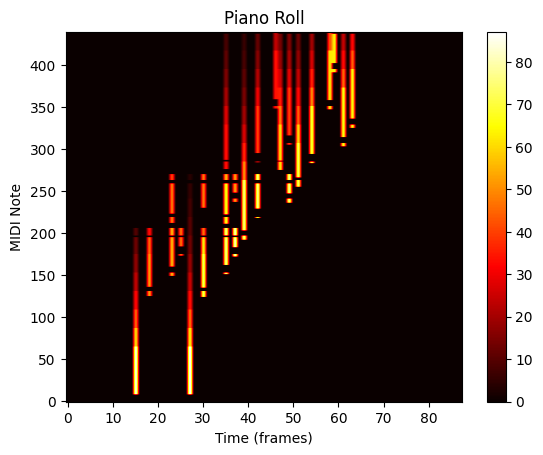

In [21]:
a, b = generate_data_label(505, segment_jump=0.5)
vis = b.reshape(b.shape[0]*b.shape[1],b.shape[2],b.shape[3] )
s = vis[:440, :,2]
print(s.shape)
plt.imshow(s, aspect='auto', cmap='hot', origin='lower')
plt.title("Piano Roll")
plt.xlabel("Time (frames)")
plt.ylabel("MIDI Note")
plt.colorbar(label="")
plt.show()


### Training functions


In [20]:
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import random
import re
import os

## MODEL Saver
def save_model(model, optimizer, id, path = "models/"):
    """ Saving the model after each training/testing before each training progress"""
    actualPath = path + f"{id}_piano_model.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, actualPath)
    
    
## MODEL loader
def load_model(model, optimizer, id, path = "models/"):
    actualPath = path + f"{id}_piano_model.pth"
    checkpoint = torch.load(actualPath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer


"""This function generates the matrix label to aligne the mal_spectral gram
each matrix should consired num_frame,
poping fram_jumping after the matrix is being yield

jumping time should be
frame_jumping * (frame_len /sr)
"""
def label_generator(num_frame, frame_jumping, jump_len:int, frame_len: int, sr:int, midi):
    midi_frame_gen = PeekableGenerator(frame_aligning_midi(0, frame_len, frame_len, sr, midi)) ## Note, while using the architechture of mel_spectrogram, the we don't need to consider the jump offset in the midi side
    label = []
    counter = 0
    
    
    concur_time = 0
    concur_time_end = 0
    frame_time = frame_len /sr

    
    while midi_frame_gen.has_next():
        if (len(label) < num_frame):
            label.append(list(midi_frame_gen.__next__()))
            concur_time_end += frame_time
            
        else:
            counter+=1
            yield label
            for i in range(int(frame_jumping)):
                label.pop(0)
                concur_time += frame_time
                


"""This function tries to mimic the decayed velocity miniking the sound at which a piano has been decayed"""
def velocity_decay_sustain (velocity, onset, at_time):
    if (at_time - onset < 0.2):
        return velocity
    else:
        return math.exp((onset - at_time) * 0.6) * velocity


"""formating the label of list, in to a matrix of 88 * 3 matrix.
    each row represent a strikable key, 
    column 1 (being stricked) : 0, 1 (classification purpose)
    column 2 (onset timer) : the set of positive interger that is less than onset. (Regression purpose)
    column 3 (velocity of which is being stricked) : the set of positive integer that is less than onset. (Regression purpose) 
        note for the velocity of the piano key will be approximately alingned with a decay parameter"""
def label_formater(label, frameonset):
    ret_label = np.zeros((len(label), 88,3))
    for i in range(len(label)) :
        for key_obj in label[i]:
            pitch = key_obj['pitch'] - 21
            ret_label[i][pitch][0] = 1
            ret_label[i][pitch][1] = key_obj['start'] - frameonset if key_obj['start'] > frameonset else 0
            ret_label[i][pitch][2] = velocity_decay_sustain(key_obj['velocity'],  key_obj['start'], frameonset) 
    
   

    return ret_label





def construct_input(spectrogram, x, y):
    """This function assure the input for the training will retain the dimension in the case of track is ending."""
    if spectrogram.shape == (x,y):
        return spectrogram
    else: 
        ret = np.zeros((x,y))
        
       
        for i in range(spectrogram.shape[0]):
            ret[i][:spectrogram.shape[1]] = spectrogram[i][:spectrogram.shape[1]]
        return ret
    
def construct_input_hcqt(spectrogram, x, y, harmonic=3):
    if (spectrogram.shape == (harmonic, x, y)):
        return spectrogram
    else :
        ret = np.zeros((harmonic, x, y))
        ret [:harmonic, :x, :y] = hcqt[:harmonic, :x, :y]
        return ret


def train_segment(wav, sr, length=1, hop=0.5):
    ret = []
    max = len(wav)/sr
    begin = 0
    while (begin < max):
        adding = length if begin + length < max else max - begin
        ret.append((begin, begin + adding))
        begin += hop

    return ret
    

def label_buffer(num_frame, label):
    """This function is used at the end of the piece, when the label doesn't extend as long of th piece"""
    if len(label) < num_frame:
        for i in range(num_frame- len(label)):
            label.append([])
    return label




def save_to_file(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f)


def load_from_file(filename):
    if not os.path.exists(filename):
        return None  # Or a default value like {} or [] based on your use case
    with open(filename, "rb") as f:
        return pickle.load(f)



""" This function will generate all the mel_spectrogram and label pair for each audio segment of the song at index"""
def generate_data_label(index, cache = False, noised=True, num_frame=22, segment_jump = 0.5, frame_length = 2048, hop_length = 512, mel = False, HCQT = True):
    # fetching infomation
    (wav, sr), midi = load_wav_midi_pair(index)
    if mel and HCQT:
        print("not supporting both spectral gram")
        return None
    if noised:
        wav = add_gaussian_noise(wav)

    #Load data and label if they have been generated already
    data_path = f"traindata/preprocessed/data/{index}.json"
    label_path = f"traindata/preprocessed/label/{index}.json"

    loaded_data = load_from_file(data_path)
    loaded_label = load_from_file(label_path)
    if type(loaded_data) != type(None) and type(loaded_label) != type(None):
        return loaded_data, loaded_label


    #asuming this is the first time generating the data label pair 

    frame_time =  frame_length/sr
    quick_sample = audio_segment_between(0, num_frame*frame_time, wav, sr)
    x, y = extract_mel_spectrogram(quick_sample, sr).shape
    segments = train_segment(wav, sr, length = num_frame * frame_time, hop= num_frame * frame_time/2)
    
    label_gen = PeekableGenerator(label_generator(num_frame, num_frame*segment_jump, hop_length, frame_length, sr, midi))
    
    input_datas = []
    labels = []
    
  
    for beg, end in segments:
        
        if (label_gen.has_next() is False) :
            break
        
        audio = audio_segment_between(beg, end, wav, sr)
        if mel: 
            mel_spectrogram = extract_mel_spectrogram(audio, sr, hop_length= hop_length, n_fft=frame_length)
            input_data = construct_input(mel_spectrogram, x,y)
            input_data = np.array(input_data)
            input_data = np.expand_dims(input_data, axis=0)
            input_datas.append(input_data)
            

        if HCQT:
            HCQT_spectrogram = extract_hcqt_spectrogram(audio, sr, hop_length=hop_length)
            input_data = construct_input_hcqt(HCQT_spectrogram, x,y, 3)
            input_data = np.array(input_data)
            input_datas.append(input_data)
        
        

        
        label = label_buffer(num_frame, label_gen.__next__())
        label = label_formater(label, beg)        
        labels.append(label)
    if cache :
        save_to_file(np.array(input_datas), data_path)
        save_to_file(np.array(labels), label_path) 
    
    return np.array(input_datas), np.array(labels)
   


def one_pass_song_train(id, index, ratio, lr = 0.001, cache = False, noised=True, num_frame=22, segment_jump = 0.5, frame_length = 2048
                        , hop_length = 512, batch_size=16, mel = False, CQT = True ):
    #load model
    """The training is based on how many frame should be trained at a time,
        the default setting is suited for the expriment set up above,
        num_frame is tried to aligned it to approx 1 second of the sample
        segment_jumping would be trying to get 50% of the sample audio
        The dimension of the input is:
        batchsize * channel * 
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if CQT:
        model = HCQTModel()
    else:
        model = PianoNoteModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    #Letting the classification utility be more potent than the regression utility.
    criterion = MultiTaskLoss(classification_weight=1.7, regression_weight=0.5)
  
    model, optimizer = load_model(model, optimizer, id)
    #override the optimizer with our lr.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # generate all data
    datas, labels = generate_data_label(index, cache = False, noised=noised, num_frame=num_frame, segment_jump=segment_jump,
                                         frame_length=frame_length, hop_length=hop_length, mel=mel, HCQT=CQT)
    datas = torch.tensor(datas, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    dataset = TensorDataset(datas, labels)
    # Let model be in training mode
    model.train()
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle =True)
    # Initialize the feedback value before training to 
    

    lossval = 0.0
    #for _, (batch_inputs, batch_labels) in progress_bar:
    for batch_inputs, batch_labels in dataloader:
        optimizer.zero_grad()

        outputs = model(batch_inputs)

        #  classification training
        classification_output = outputs[..., 0:1]
        classification_target = batch_labels[..., 0:1]
        
        #  regression training
        regression_output = outputs[..., 1:3]
        regression_target = batch_labels[...,1:3]
        loss = criterion.forward(classification_output, classification_target, regression_output, regression_target, ratio)
    
        

        loss.backward()
        optimizer.step()

        lossval+= loss.item()

        
    #save model
    save_model(model, optimizer, id)
    return lossval

def save_training_message_log(id, log):
    # Open the file in write mode and write the string
    path = "models/"+ id + "_training_log.txt"
    with open(path, "w") as file:
        file.write(log)

def extract_ratios_from_log_file(id):
    path = "models/"+ id + "_training_log.txt"
    # Open the file and read its contents
    with open(path, 'r') as file:
        text = file.read()
    # Regular expression to match "Ratio of pressed is in data is <value>"
    pattern = r"The ratio was trained with (\d+\.\d+)"
 
    # Find all matching ratios in the text
    ratios = re.findall(pattern, text)
    
    # Convert each ratio to a float for easier processing (optional)
    return [float(ratio) for ratio in ratios]

def extract_fc_from_log_file(id):
    path = "models/"+ id + "_training_log.txt"
    # Open the file and read its contents
    with open(path, 'r') as file:
        text = file.read()
    # Regular expression to match "Ratio of pressed is in data is <value>"
    pattern = r"Frame_accuracy: (\d+\.\d+)"
 
    # Find all matching ratios in the text
    ratios = re.findall(pattern, text)
    
    # Convert each ratio to a float for easier processing (optional)
    return [float(ratio) for ratio in ratios]

def extract_pc_from_log_file(id):
    path = "models/"+ id + "_training_log.txt"
    # Open the file and read its contents
    with open(path, 'r') as file:
        text = file.read()
    # Regular expression to match "Ratio of pressed is in data is <value>"
    pattern = r"pressed_corrected: (\d+\.\d+)"
 
    # Find all matching ratios in the text
    ratios = re.findall(pattern, text)
    
    # Convert each ratio to a float for easier processing (optional)
    return [float(ratio) for ratio in ratios]

def loss(pc, fc):
    return abs(1-pc) + abs(1-fc)

def train_N_song_on_epoch (id, epoch, N, back_up, lr = 0.001, cache = False, ratio_update = True, ratio_load_prev = True, ratio=1.5, ratio_dummy = 1.51, pc = 0.7928640553348053,
                            fc = 0.5865201712217555, repetition = 2, noised=True, CQT = True, Mel= False):
    
    """prev_ratio = extract_ratios_from_log_file(id)[-1]
    if (prev_ratio != None and ratio_load_prev):
        prev = prev_ratio"""
    
    tobe_done = load_progress_index_from_csv(epoch, id)

    N = min(N, len(tobe_done))
    ## indices to be trained for the current run
    parse_in = [tobe_done.pop() for _ in range(N)]

    random.shuffle(parse_in)

    progress = tqdm.tqdm(parse_in)
    counter = 0
    trained = []
    ## Passing in each index to train on one_pass_song_train
    training_message = ""
    for index in progress:
        
        for rep in range(repetition):
            loss = one_pass_song_train(id, index, ratio, noised=noised, lr = lr)
            training_message += f"loss value at {index} on {rep} is {loss}" + '\n' 
            
        trained.append(index)
        counter += 1
        """if (counter % 7 == 0):
            new_pc, new_fc, _ = validation_N_songs(id, 5)
            
            training_message += '\n' + f"The ratio was trained with {ratio}. Trained {len(trained)} songs." + '\n'
            training_message += f"pressed_corrected: {new_pc}. Frame_accuracy: {new_fc}." + '\n'
            dl = loss(new_pc, new_fc) - loss(pc, fc)
            dr = ratio - ratio_dummy + 1e-5
            pc = new_pc
            fc = new_fc
            if (ratio_update):
                ratio_dummy = ratio
                ratio = ratio + 0.1*(dl/dr)"""
        #save this to a messaage file
        
        #save_training_message_log(id, training_message)
    save_training_message_log(id, training_message)
    

    new_pc, new_fc, _ = validation_N_songs(id, 10)
            
    training_message += '\n' + f"The ratio was trained with {ratio}. Trained {len(trained)} songs." + '\n'
    training_message += f"pressed_corrected: {new_pc}. Frame_accuracy: {new_fc}." + '\n'
    save_training_message_log(id, training_message)
    
    if (len(tobe_done) == 0):
        print(f"Epoch {epoch} training complete.")
        save_progress_index_to_csv(tobe_done, epoch, id)
    else :
        
        print(f"Epoch {epoch} have trained {N} songs, left over songs for current epoch will be saved. Need to train {len(tobe_done)}.")
        save_progress_index_to_csv(tobe_done, epoch, id)
    actualPath = f"models/{id}_piano_model.pth"
    print(f"Model saved to {actualPath}")

    if CQT:
        model = HCQTModel()
    else:
        model = PianoNoteModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    #Letting the classification utility be more potent than the regression utility.
  
    model, optimizer = load_model(model, optimizer, id)

    back_up_id = "" + id + back_up
    save_model(model, optimizer, back_up_id)
    save_training_message_log(back_up_id, training_message)
    print(f"back_up_id {id} + {back_up}")

def model_roll_back(fromID, BackupID):
    model = PianoNoteModel(output_size=(88, 3))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    model, optimizer = load_model(model, optimizer, BackupID)
    save_model(model, optimizer, fromID)



### Validation functions

Use the function below to test the accuracy of the model

(1065, 3, 88, 89)


In [57]:

def validation_accuracy_check(id, index, noised=True, num_frame=22, segment_jump = 0.5, frame_length = 2048, hop_length = 512, batch_size=16, CQT=True):
    """This function returns the accuracy of the model predicting the song at index
        arguments:
            id: trained model id
            index: index of the song.
    """
    if CQT:
        model = HCQTModel()
    else:
        model = PianoNoteModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    #Letting the classification utility be more potent than the regression utility.
    criterion = MultiTaskLoss(classification_weight=1.5, regression_weight=0.7)
 
    
    model, optimizer = load_model(model, optimizer, id)
   

    datas, labels = generate_data_label(index, num_frame=num_frame, segment_jump=segment_jump, frame_length=frame_length, hop_length=hop_length)
    

    datas = torch.tensor(datas, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    dataset = TensorDataset(datas, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    classification_correct = 0
    classification_true_correct = 0
    regression_error = 0

    true_classified = 0
    total_classifed = 0
    num_classified = 0
    
    with torch.no_grad():
        
        for val_inputs, val_labels in dataloader:
            outputs = model(val_inputs)

            #Output separation
            classification_outputs = outputs[:,:,:, 0:1].squeeze(-1)
            regression_outputs = outputs[:, :, :, 1:3]

            #Label separation
            classification_labels = val_labels[:, :, :, 0:1].squeeze(-1)
            regression_labels = val_labels[:, :, :, 1:3]
            
            #Calculate the classification accuracy of a frame
            predicted_classes = (classification_outputs > 0.5).float()
            classification_correct += (predicted_classes == classification_labels).sum().item() / model.num_mel_bins #this should be the accuracy of a frame


            #Calculate the classification accuracy of pressed key
            pressed_key_mask = classification_labels == 1
            pressed_key_label = classification_labels[pressed_key_mask]
            pressed_key_prediction = predicted_classes[pressed_key_mask]
            true_classified += pressed_key_label.numel()
            total_classifed += classification_labels.numel()
            classification_true_correct += (pressed_key_label == pressed_key_prediction).sum().item()
            

            regression_error += ((regression_outputs - regression_labels) ** 2).mean().item()
            
            num_classified += val_labels.shape[0] * val_labels.shape[1] # counting number of frames have been classified i.e. batch_number * number of frame per segment
            

    if true_classified > 0 :
        true_accuracy = classification_true_correct/true_classified
    else:
        true_accuracy = 0
    
 
    return true_accuracy, classification_correct/ num_classified, 



import numpy as np




"""Validating N random songs from the validation set and returns the average of their accuracy in frames and pressed_notes"""
def validation_N_songs(id, N, cache = False, mel= False, CQT =True, model=None, optimizer=None, noised=True, num_frame=22, segment_jump = 0.5, frame_length = 2048, hop_length = 512, batch_size=16):
    if model == None and optimizer == None:
        if CQT:
            model = HCQTModel()
        else:
            model = PianoNoteModel()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        model, optimizer = load_model(model, optimizer, id)
    all_indices = load_index_from_csv("traindata/maestro-v3.0.0-midi/maestro-v3.0.0/validation_indicies.csv")
    indices_subset = random.sample(all_indices,N)

    classification_correct = 0
    classification_true_correct = 0
    regression_error = 0

    true_classified = 0
    total_classifed = 0
    num_classified = 0


    ##Use the bellow to calculate the f1 score
    true_positive = 0
    false_positive = 0
    false_negative = 0

    with torch.no_grad():
        for index in indices_subset:
            datas, labels = generate_data_label(index, num_frame=num_frame, segment_jump=segment_jump, frame_length=frame_length, hop_length=hop_length, HCQT=CQT, mel = mel)
            datas = torch.tensor(datas, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.float32)
            dataset = TensorDataset(datas, labels)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
            for val_inputs, val_labels in dataloader:
                outputs = model(val_inputs)

                #Output separation
                classification_outputs = outputs[:,:,:, 0:1].squeeze(-1)
                regression_outputs = outputs[:, :, :, 1:3]

                #Label separation
                classification_labels = val_labels[:, :, :, 0:1].squeeze(-1)
                regression_labels = val_labels[:, :, :, 1:3]
                
                #Calculate the classification accuracy of a frame
                predicted_classes = (classification_outputs > 0.5).float()
                if CQT:
                    bin = model.num_cqt_bins
                else:
                    bin = model.num_mel_bins
                classification_correct += (predicted_classes == classification_labels).sum().item()/bin  #this should be the accuracy of a frame

                true_positive += torch.sum((classification_labels == 1) & (predicted_classes == 1.0)).item()
                false_positive += torch.sum((classification_labels == 0) & (predicted_classes == 1.0)).item()
                false_negative += torch.sum((classification_labels == 1) & (predicted_classes == 0)).item()

                
                #Calculate the classification accuracy of pressed key
                pressed_key_mask = classification_labels == 1
                pressed_key_label = classification_labels[pressed_key_mask]
                pressed_key_prediction = predicted_classes[pressed_key_mask]
                true_classified += pressed_key_label.numel() 
                total_classifed += classification_labels.numel()
                classification_true_correct += (pressed_key_label == pressed_key_prediction).sum().item()
                

                regression_error += ((regression_outputs - regression_labels) ** 2).mean().item()
                
                num_classified += val_labels.shape[0] * val_labels.shape[1]
    if true_classified > 0 :
        true_accuracy = classification_true_correct/true_classified
    else:
        true_accuracy = 0
    print(f"True accuracy{true_accuracy}, Frame accuracy {classification_correct/num_classified}.")
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    

    print(f"F1 Score is {f1_score}")
    return true_accuracy, classification_correct/ num_classified, true_classified/total_classifed, f1_score






# Training

### Index Processing

Using the saved indices we have processed before  
Here are the file paths  
for training datas :traindata/maestro-v3.0.0-midi/maestro-v3.0.0/train_indicies.csv  
for test datas :traindata/maestro-v3.0.0-midi/maestro-v3.0.0/test_indicies.csv   
for validataion datas :traindata/maestro-v3.0.0-midi/maestro-v3.0.0/validation_indicies.csv  

In [59]:
## Only run this once
train_indices = load_index_from_csv("traindata/maestro-v3.0.0-midi/maestro-v3.0.0/train_indicies.csv")
validation_indices = load_index_from_csv("traindata/maestro-v3.0.0-midi/maestro-v3.0.0/validation_indicies.csv")
test_indices = load_index_from_csv("traindata/maestro-v3.0.0-midi/maestro-v3.0.0/test_indicies.csv")

def initiate_train_epoch(id, epoch_Number, dataset):
    train_indices = load_index_from_csv(dataset)
    train_indices = randomizeing(train_indices)
    save_progress_index_to_csv(train_indices, epoch_Number, id)


In [ ]:
# Initiate the training epoch. RUN ONCE BEFORE TRAINING
#initiate_train_epoch(0, "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/train_indicies.csv")

# Initiate the training model. RUN ONCE BEFORE TRAINING
model = PianoNoteModel(output_size=(88, 3))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
save_model(model, optimizer, "test")
train_N_song_on_epoch(id, 0, 3, "0", ratio_update=False, ratio_load_prev=False, ratio=1.5)


OSError: [Errno 22] Invalid argument: 'models/training_index0_for_<built-in function id>.csv'

## Trainign prototype
Experimenting training on one single sample to see if there are any progresses.

In [43]:
"""
model = PianoNoteModel(output_size=(88, 3))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

initiate_train_epoch(id, 0, "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/train_indicies.csv")
save_model(model, optimizer, id)"""
id = "first_prototype_ep0"
train_N_song_on_epoch(id, 0, 100, "0", ratio_update=False, ratio_load_prev=False, ratio=1.52)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\youxu\AppData\Local\Temp\ipykernel_17368\3740269339.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

NameError: name 'log' is not defined

In [49]:
id = "prototype2"
#initiate_train_epoch(id, 0, "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/train_indicies.csv")
#model, optimizer = load_model(model, optimizer, id)
#save_model(model, optimizer, "prototype2")
train_N_song_on_epoch(id, 0, 50, "0", ratio_update=False, ratio_load_prev=False, ratio=1.49)


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\youxu\AppData\Local\Temp\ipykernel_21596\3773330733.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

True accuracy0.9195278684721219, Frame accuracy 0.6290750926471438.
Epoch 0 have trained 50 songs, left over songs for current epoch will be saved. Need to train 862.
Model saved to models/prototype2_piano_model.pth
back_up_id prototype2 + 0


In [58]:
id = "test20"
validation_N_songs(id, 5)

C:\Users\youxu\AppData\Local\Temp\ipykernel_23244\1798625916.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(actualPath)


True accuracy0.8608380691963147, Frame accuracy 0.7615625560863881.
F1 Score is 0.27432351938988636


(0.8608380691963147,
 0.7615625560863881,
 0.052353171177792784,
 0.27432351938988636)

In [47]:

#model = HCQTModel(output_size=(88, 3))
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
id = "test2"
#initiate_train_epoch(id, 0, "traindata/maestro-v3.0.0-midi/maestro-v3.0.0/train_indicies.csv")
#save_model(model, optimizer, id)
train_N_song_on_epoch(id, 0, 100, "0", ratio_update=False, ratio_load_prev=False, ratio=1.50)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\youxu\AppData\Local\Temp\ipykernel_4616\1978453765.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

True accuracy0.8397788937371643, Frame accuracy 0.7604312628161313.
Epoch 0 have trained 100 songs, left over songs for current epoch will be saved. Need to train 652.
Model saved to models/test2_piano_model.pth
back_up_id test2 + 0


In [50]:
train_N_song_on_epoch(id, 0, 150, "3", ratio_update=False, ratio_load_prev=False, ratio=1.50)

  0%|          | 0/150 [00:00<?, ?it/s]C:\Users\youxu\AppData\Local\Temp\ipykernel_4616\1978453765.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

True accuracy0.7519307791188689, Frame accuracy 0.7688797749912148.
Epoch 0 have trained 150 songs, left over songs for current epoch will be saved. Need to train 282.
Model saved to models/test2_piano_model.pth
back_up_id test2 + 3


In [58]:
train_N_song_on_epoch(id, 0, 20, "", ratio_update=False, ratio_load_prev=False, ratio=1.50, lr = 0.001)

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\youxu\AppData\Local\Temp\ipykernel_4616\2606194280.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

KeyboardInterrupt: 

In [61]:
backup = id + "3"
validation_N_songs(backup, 4)

C:\Users\youxu\AppData\Local\Temp\ipykernel_4616\1798625916.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(actualPath)


True accuracy0.7683766613115233, Frame accuracy 0.7648542814077529.


(0.7683766613115233, 0.7648542814077529, 0.05314310373732544)

In [58]:
def weightadjsut (pc, new_pc, fc, new_fc, weight):
    delta = 0.1 * ((new_pc - pc) - 0.7* (new_fc - fc) )
    return weight + delta
"""ArithmeticError
Classified 29128 frames of audio, classification arcuracy 0.22729457441761755, average regression error is 0.16237703282094468
The true accuracy of classifying pressed_key are 0.9963199053689952
Ratio of pressed is in data is 0.029682857481710817
The ratio was trained with 1.7045658300552646. Trained 84 songs.
Classified 27456 frames of audio, classification arcuracy 0.16490310116020349, average regression error is 0.16563519005314176
The true accuracy of classifying pressed_key are 0.999739833168019
Ratio of pressed is in data is 0.02545353557427421
The ratio was trained with 1.7208529809521513. Trained 91 songs.
"""
weightadjsut(0.22729457441761755)

1.503

# Using the model

Below are functions to use for trained model

In [ ]:

def model_output(id, index, CQT=True):
    """ This function returns the audio classification from the model {id}
        arguments : id (model id)
                    index (song index)
            return: classification result
    """
    if CQT:
        model = HCQTModel()
    else:
        model = PianoNoteModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    model, _ = load_model(model, optimizer, id)
    audio_data = generate_data(index)


    datas = torch.tensor(audio_data, dtype=torch.float32)


    dataloader = DataLoader(audio_data, batch_size = 16, shuffle =True)
    


    dataset = TensorDataset(datas, labels)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle =True)

    
    progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))

    epoch_loss = 0.0
    for batch_inputs, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)




def midi_reconstruction(outputed_data):
    """Reconstruct the midi object from the outputed_data.
        Arguments:
            outputed_data: A list of outputed matrixies[batch_size * frame_number * 88 * 3]
    """

In [49]:
from preprocess import dothings

dothings()

ImportError: cannot import name 'dothings' from 'src.dummy' (c:\Users\youxu\OneDrive\Desktop\Projects\Musheet\src\dummy.py)